In [1310]:
%pip install seglearn

     |████████████████████████████████| 11.3 MB 3.0 MB/s 
     |████████████████████████████████| 14.8 MB 450 kB/s 
     |████████████████████████████████| 22.3 MB 12.5 MB/s 
     |████████████████████████████████| 302 kB 28.9 MB/s 
     |████████████████████████████████| 27.4 MB 19.6 MB/s 
You should consider upgrading via the '/usr/bin/python3.7 -m pip install --upgrade pip' command.


In [1311]:
import argparse
import datetime
import bisect
import pandas as pd
import numpy as np

from collections import defaultdict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

from seglearn.pipe import Pype
from seglearn.split import temporal_split, TemporalKFold
from seglearn.transform import FeatureRep, Segment, last


import matplotlib.pyplot as plt
from sklearn import preprocessing

from sklearn.ensemble import RandomForestRegressor

import math

from scipy.stats import spearmanr

In [1312]:
class HardwareLogItem:
    def __init__(self,
                 date,
                 time,
                 cpu_usage_value,
                 mem_usage_in_gb,
                 gpu_avg_mem_usage,
                 gpu_max_mem_usage,
                 gpu_temp,
                 gpu_power_consumption,
                 gpu_utilization):
        self.timestamp = datetime.datetime.strptime(" ".join([date, time]), '%Y-%m-%d %H:%M:%S.%f')
        self.cpu_usage_value = cpu_usage_value
        self.mem_usage_in_gb = mem_usage_in_gb
        self.gpu_avg_mem_usage = gpu_avg_mem_usage
        self.gpu_max_mem_usage = gpu_max_mem_usage
        self.gpu_temp = gpu_temp
        self.gpu_power_consumption = gpu_power_consumption
        self.gpu_utilization = gpu_utilization

    def key(self):
        return self.timestamp

    def value(self):
        return [self.cpu_usage_value,
                self.mem_usage_in_gb,
                self.gpu_avg_mem_usage,
                self.gpu_max_mem_usage,
                self.gpu_temp,
                self.gpu_power_consumption,
                self.gpu_utilization]

    def to_features_dict(self):
        return {"cpu_usage_value": self.cpu_usage_value,
                "mem_usage_in_gb": self.mem_usage_in_gb,
                "gpu_avg_mem_usage": self.gpu_avg_mem_usage,
                "gpu_max_mem_usage": self.gpu_max_mem_usage,
                "gpu_temp": self.gpu_temp,
                "gpu_power_consumption": self.gpu_power_consumption,
                "gpu_utilization": self.gpu_utilization
                }
    
class NetworkLogItem:
    def __init__(self,
                 timestamp,
                 connections_count,
                 opened_files,
                 read_ops,
                 write_ops,
                 read_bytes,
                 write_bytes):
            
        self.timestamp = timestamp
        self.connections_count = connections_count
        self.opened_files = opened_files
        self.read_ops = read_ops
        self.write_ops = write_ops
        self.read_bytes = read_bytes
        self.write_bytes = write_bytes

    def key(self):
        return self.timestamp

    def value(self):
        return [self.connections_count,
                self.opened_files,
                self.read_ops,
                self.write_ops,
                self.read_bytes,
                self.write_bytes]

    def to_features_dict(self):
        return {"connections_count": self.connections_count,
                "opened_files": self.opened_files,
                "read_ops": self.read_ops,
                "write_ops": self.write_ops,
                "read_bytes": self.read_bytes,
                "write_bytes": self.write_bytes
                }
    
class PreRequestInfo:
    def __init__(self, normalize_partials, sample_rate, channels_count, session_user_id):
        self.normalize_partials = normalize_partials
        self.sample_rate = sample_rate
        self.channels_count = channels_count
        self.session_user_id = session_user_id
        
class SessionItem:
    def __init__(self,
                 start_timestamp,
                 normalize_partials,
                 sample_rate,
                 channels_count,
                 received_time,
                 session_time,
                 session_user_id):
        self.start_timestamp = start_timestamp
        self.normalize_partials = normalize_partials
        self.sample_rate = sample_rate
        self.channels_count = channels_count
        self.received_time = received_time
        self.session_time = session_time
        self.session_user_id = session_user_id

    def to_features_dict(self):
        return {"normalize_partials": self.normalize_partials,
                "sample_rate": self.sample_rate,
                "channels_count": self.channels_count,
                #"received_time": self.received_time
                }

    def get_received_time(self):
        return self.received_time
    
    def get_session_user_id(self):
        return self.session_user_id

    def get_session_time(self):
        return self.session_time

    def label(self):
        #if self.received_time == 0:
        #    print(self.to_features_dict(), self.get_session_time())
        #return self.received_time / (self.session_time * 1000.0) < 0.5

        return self.session_time * 1000.0

In [1313]:
def parse_hardware_log(log_path):
    result_items = []
    with open(log_path, 'r') as log_file:
        for log_line in log_file.readlines():
            items = log_line.split()
            log_level, date, time, zone, file_ = items[0], items[1], items[2], items[3], items[4]
            cpu_usage_value, mem_usage_in_gb = float(items[5]), float(items[6])
            gpu_avg_mem_usage, gpu_max_mem_usage = float(items[7]), float(items[8])
            gpu_temp, gpu_power_consumption, gpu_utilization = float(items[9]), float(items[10]), float(items[11])

            result_items.append(HardwareLogItem(date,
                                                time,
                                                cpu_usage_value,
                                                mem_usage_in_gb,
                                                gpu_avg_mem_usage,
                                                gpu_max_mem_usage,
                                                gpu_temp,
                                                gpu_power_consumption,
                                                gpu_utilization))

    return result_items

In [1314]:
def parse_server_log(log_path):
    session_id_to_features = defaultdict(dict)
    chunks_ts = []
    with open(log_path, 'r') as log_file:
        for log_line in log_file.readlines():
            session_id = None
            #  starting session log line
            if "Starting session" in log_line:
                info_parts = log_line.split("#")[-1].split()
                session_id = info_parts[0]
                session_id_to_features[session_id]["start_timestamp"] = info_parts[-1]
            #  session info + req params
            elif "server.cpp:94" in log_line:
                info_parts = log_line.split()
                session_id = info_parts[-5]
                normalize_partials = int(info_parts[-4])
                sample_rate = int(info_parts[-3])
                channels_count = int(info_parts[-2])
                session_user_id = int(info_parts[-1])
                pre_request_info = PreRequestInfo(normalize_partials, sample_rate, channels_count, session_user_id)
                session_id_to_features[session_id]["pre_request_info"] = pre_request_info
            #  starting session log line
            elif "finish recognition" in log_line:
                info_parts = log_line.split()
                session_id = info_parts[-6]
                received_time = float(info_parts[-1].split("=")[-1])
                session_id_to_features[session_id]["time_info"] = received_time
            #  finish session log line
            elif "Session" in log_line and "was finished at" in log_line:
                info_parts = log_line.split("#")[-1].split()
                session_id = info_parts[0]
                session_id_to_features[session_id]["finish_timestamp"] = info_parts[-1]
            #elif log_line.split()[-1] == "nc":
            #    parts = log_line.split()
            #    ts = " ".join(parts[1:3])
            #    ts = datetime.datetime.strptime(ts, '%Y-%m-%d %H:%M:%S.%f')
            #    chunks_ts.append(ts)
            # if session_id is not None:
            #    print(session_id_to_features[session_id])

    return session_id_to_features, chunks_ts

In [1315]:
def sessions_info_to_vec(completed_session_id_to_features, session_id_to_features):
    result_items = []
    for k, v in completed_session_id_to_features.items():
        session_time = (completed_session_id_to_features[k]["finish_timestamp"] - completed_session_id_to_features[k][
            "start_timestamp"]).total_seconds()
        pre_request_info = completed_session_id_to_features[k]["pre_request_info"]
        normalize_partials = pre_request_info.normalize_partials
        sample_rate = pre_request_info.sample_rate
        channels_count = pre_request_info.channels_count
        received_time = session_id_to_features[k]["time_info"]
        result_items.append(
            SessionItem(completed_session_id_to_features[k]["start_timestamp"], normalize_partials, sample_rate,
                        channels_count, received_time, session_time, pre_request_info.session_user_id))

    return result_items

In [1316]:
def load_network_log(log_path):
    timestamp_to_network_item = {}
    with open(log_path, 'r') as log_file:
        for log_line in log_file.readlines():
            # INFO 2020-12-03 07:34:24.187 19 271 0 16 0 90112
            parts = log_line.split()
            count = int(parts[-6])
            opened_files = int(parts[-5])
            read_ops = int(parts[-4])
            write_ops = int(parts[-3])
            read_bytes = int(parts[-2])
            write_bytes = int(parts[-1])
            parts = parts[:-6]
            parts = parts[1:]
            ts = " ".join(parts)
            ts = datetime.datetime.strptime(ts, '%Y-%m-%d %H:%M:%S.%f')
            timestamp_to_network_item[ts] = NetworkLogItem(ts, count, opened_files, read_ops, write_ops, read_bytes, write_bytes)
    
    
    print(list(timestamp_to_network_item.values())[:3])
    return timestamp_to_network_item

In [1317]:
def load_data(df):
    return df.to_numpy()[:, :-1], df.to_numpy()[:, -1], df.keys()

In [1318]:
def plot_hardware(hardware_log):
    for key in hardware_log[0].to_features_dict().keys():
        plt.clf()
        X = list(range(len(hardware_log)))
        plt.plot(X, list(map(lambda t: t.to_features_dict()[key], hardware_log)))
        plt.title(f'{key} distribution')
        plt.savefig(f'{key}_distribution.png')

In [1319]:
def train_simple(df):
    Xs, ys, keys = load_data(df)

    X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.2, random_state=42)
    model = RandomForestClassifier(random_state=42)

    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    metrics = precision_recall_fscore_support(y_test, y_hat, average='binary')
    scores = {'accuracy': accuracy_score(y_test, y_hat),
              'precision': metrics[0], 'recall': metrics[1], 'F-score': metrics[2], 'support': metrics[3]}
    print(scores)

In [1320]:
def train_time_split(df):
    Xs, ys, keys = load_data(df)
    train_size= int(0.8 * len(Xs))
    X_train, X_test, y_train, y_test = Xs[:train_size], Xs[train_size:], ys[:train_size], ys[train_size:]
    model = RandomForestClassifier(random_state=42)

    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    print(y_train, y_hat)
    metrics = precision_recall_fscore_support(y_test, y_hat, average='binary')
    scores = {'accuracy': accuracy_score(y_test, y_hat),
              'precision': metrics[0], 'recall': metrics[1], 'F-score': metrics[2], 'support': metrics[3]}
    print(scores)

In [1321]:
def train_time_series(df, intervals=20, classifiers_count=10):
    Xs, ys, keys = load_data(df)

    N = len(Xs)
    interval_size = int(N / intervals)
    print(f'Interval size: {interval_size}')

    models = []
    accs = []
    for it in range(intervals):
        if it < classifiers_count:
            Xs_it, ys_it = Xs[it * interval_size: (it + 1) * interval_size], ys[it * interval_size: (it + 1) * interval_size]
            train_size = int(0.8 * len(Xs_it))
            print(f'Initial step set size: {len(Xs_it)}, train_size = {train_size}')
            X_train, X_test, y_train, y_test = Xs_it[:train_size], Xs_it[train_size:], ys_it[:train_size], ys_it[train_size:]
            model = RandomForestClassifier(random_state=42 * (it + 1))
            model.fit(X_train, y_train)
            models.append(model)
        else:
            Xs_it, ys_it = Xs[it * interval_size: (it + 1) * interval_size], ys[it * interval_size: (it + 1) * interval_size]
            train_size = int(0.8 * len(Xs_it))
            print(f'Step set size: {len(Xs_it)}, train_size = {train_size}')
            X_train, X_test, y_train, y_test = Xs_it[:train_size], Xs_it[train_size:], ys_it[:train_size], ys_it[train_size:]
            model = RandomForestClassifier(random_state=42 * (it + 1))
            model.fit(X_train, y_train)
            models.append(model)

            worst_i, worst_acc = -1, 0
            for i, m in enumerate(models):
                y_hat = m.predict(X_test)
                accuracy = accuracy_score(y_test, y_hat)
                if worst_i == -1 or worst_acc > accuracy:
                    worst_i = i
                    worst_acc = accuracy

            del models[worst_i]

            predictions = []
            for i, m in enumerate(models):
                predictions.append(m.predict(X_test))

            #print(predictions)
            predictions = np.array(predictions)
            #print(predictions)
            predictions = np.sum(predictions, axis=0)
            #print(predictions)
            y_hat_all = (predictions >= int(classifiers_count / 2)).astype(int)
            accuracy = accuracy_score(y_test, y_hat_all)
            print(f'Accuracy at step: {accuracy}')
            accs.append(accuracy)


    plt.clf()
    X = list(range(len(accs)))
    plt.plot(X, accs)
    plt.savefig(f'accuracy_distribution_time_series_segs_{intervals}_classifiers_{classifiers_count}.png')



In [1322]:
def train_seglearn(df):
    X, y, keys = load_data(df)
    X = [X]
    y = [y]
    X_train, X_test, y_train, y_test = temporal_split(X, y)

    pipe = Pype([('seg', Segment(width=200, overlap=0.5, y_func=last)),
                 ('features', FeatureRep()),
                 ('lin', RandomForestClassifier())])

    # fit and score
    pipe.fit(X_train, y_train)
    score = pipe.score(X_test, y_test)

    print("N series in train: ", len(X_train))
    print("N series in test: ", len(X_test))
    print("N segments in train: ", pipe.N_train)
    print("N segments in test: ", pipe.N_test)
    print("Score: ", score)


def train_time_series_all(df):
    train_time_series(df)
    train_time_series(df, intervals=50)
    train_time_series(df, intervals=50, classifiers_count=5)
    train_time_series(df, intervals=100, classifiers_count=5)
    train_time_series(df, intervals=100, classifiers_count=10)
    train_time_series(df, intervals=100, classifiers_count=2)
    train_time_series(df, intervals=100, classifiers_count=40)

In [1323]:
def load_stress_test_log(log_path):
    timestamp_to_timing = {}
    timestamp_to_connections = {}
    cur_connections = 0
    time_first = None
    time_last = None
    user_session_id_to_latency = {}
    with open(log_path, 'r') as log_file:
        for log_line in log_file.readlines():
            parts = log_line.split()
            ts = " ".join([parts[1], parts[2]])
            ts = datetime.datetime.strptime(ts, '%Y-%m-%d %H:%M:%S.%f')
            if time_first is None: 
                time_first = ts
                
            time_last = ts
            if parts[0] == "WARNING":
                cur_connections = int(parts[5].split("=")[1])
                #timestamp_to_connections[ts] = cur_connections
            elif parts[0] == "INFO:" and parts[5] == "STATS":
                timing = int(parts[6])
                user_id = int(parts[9])
                timestamp_to_connections[ts] = cur_connections
                timestamp_to_timing[ts] = (timing, user_id)
                user_session_id_to_latency[user_id] = timing
    
    
    
    return timestamp_to_timing, timestamp_to_connections, time_first, time_last, user_session_id_to_latency

In [1324]:
def train_time_split_regr(df):
    Xs, ys, keys = load_data(df)
    train_size= int(0.8 * len(Xs))
    X_train, X_test, y_train, y_test = Xs[:train_size], Xs[train_size:], ys[:train_size], ys[train_size:]
    model = RandomForestRegressor(random_state=42)

    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    #print(y_train, y_hat)
    #metrics = precision_recall_fscore_support(y_test, y_hat, average='binary')
    #scores = {'accuracy': accuracy_score(y_test, y_hat),
    #          'precision': metrics[0], 'recall': metrics[1], 'F-score': metrics[2], 'support': metrics[3]}
    print(scores)

In [1501]:
DATA_DIR = "final_data_big"
EXP_SUFFIX = "-big2"
EXP_INDEX = 0
THRESHOLD = 800


class ExperimentInfo:
    def __init__(self, server_log_path, cpu_gpu_log_path, disk_network_log_path, user_latency_log_path):
        self.server_log_path = DATA_DIR + "/" + server_log_path
        self.cpu_gpu_log_path = DATA_DIR + "/" + cpu_gpu_log_path
        self.disk_network_log_path = DATA_DIR + "/" + disk_network_log_path
        self.user_latency_log_path = DATA_DIR + "/" + user_latency_log_path

In [1502]:
experiments_list = []
experiments_list.append(ExperimentInfo(f'carrie-server{EXP_SUFFIX}.log', f'carrie-gpu{EXP_SUFFIX}.log', f'carrie-io{EXP_SUFFIX}.log', f'dracula-stress{EXP_SUFFIX}.log'))
experiments_list.append(ExperimentInfo(f'ctulhu-server{EXP_SUFFIX}.log', f'ctulhu-gpu{EXP_SUFFIX}.log', f'ctulhu-io{EXP_SUFFIX}.log', f'asr2-stress{EXP_SUFFIX}.log'))
experiments_list.append(ExperimentInfo(f'balrog-server{EXP_SUFFIX}.log', f'balrog-gpu{EXP_SUFFIX}.log', f'balrog-io{EXP_SUFFIX}.log', f'asr1-stress{EXP_SUFFIX}.log'))

In [1503]:
def create_dataset(experiment):
    hardware_log_list = parse_hardware_log(experiment.cpu_gpu_log_path)
    print(f'hardware log items: {len(hardware_log_list)}')
    hardware_log_list = list(sorted(hardware_log_list, key=lambda it: it.key()))
    hardware_log_list_dates = list(map(lambda it: it.key(), hardware_log_list))

    session_id_to_features, _ = parse_server_log(experiment.server_log_path)
    print(f'All sessions presented: {len(session_id_to_features)}')

    completed_session_id_to_features = defaultdict(dict)
    for k, v in session_id_to_features.items():
        if len(v.keys()) == 4:
            completed_session_id_to_features[k] = v
            
    for k, v in completed_session_id_to_features.items():
        completed_session_id_to_features[k]["start_timestamp"] = datetime.datetime.strptime(v["start_timestamp"],
                                                                                            '%Y-%m-%dT%H:%M:%S.%fZ')
        completed_session_id_to_features[k]["finish_timestamp"] = datetime.datetime.strptime(v["finish_timestamp"],
                                                                                             '%Y-%m-%dT%H:%M:%S.%fZ')

    print(f'Completed sessions: {len(completed_session_id_to_features)}')
    sessions_log = sessions_info_to_vec(completed_session_id_to_features, session_id_to_features)
    print(f'Session log len: {len(sessions_log)}')
    hardware_log_set = set(hardware_log_list)
    
    session_hardware_pairs = []
    timestamp_to_network_item = load_network_log(experiment.disk_network_log_path)
    network_dates = list(sorted(list(map(lambda it: it[0], timestamp_to_network_item.items()))))
    print(len(network_dates))
    for session in sessions_log:
        i = bisect.bisect_left(hardware_log_list_dates, session.start_timestamp, lo=0, hi=len(hardware_log_list_dates))
        j = bisect.bisect_left(network_dates, session.start_timestamp, lo=0, hi=len(network_dates))
        session_hardware_pairs.append((session, hardware_log_list[i], timestamp_to_network_item[network_dates[j]]))
    
    dataset_dicts = {}
    
    timestamp_to_timing, timestamp_to_connections, time_first, time_last, user_session_id_to_latency = load_stress_test_log(experiment.user_latency_log_path)
    
    
    labels = []
    dataset = []
    for s, h, conn in session_hardware_pairs:
        features_vec = {**s.to_features_dict(), **h.to_features_dict(), **conn.to_features_dict()}
        #features_vec["conn"] = conn
        features_vec["label"] = user_session_id_to_latency[s.session_user_id] 
        dataset.append(features_vec)
        #print(features_vec)
        labels.append(s.label())
        #break

    labels = list(sorted(labels))
    
    timestamp_to_connections_X_axis = list(map(lambda ts: (ts - time_first).total_seconds(), list(timestamp_to_connections.keys())))
    timestamp_to_connections_Y_axis = list(timestamp_to_connections.values())
    
    return dataset, labels, timestamp_to_connections_X_axis, timestamp_to_connections_Y_axis
    

In [1504]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [1505]:
class DatasetDescription:
    def __init__(self, arg):
        dataset_dicts, _, timestamp_to_connections_X_axis, timestamp_to_connections_Y_axis = arg
        dataset_dicts_mapped = []
        print(len(dataset_dicts))
        
        df_init = pd.DataFrame(dataset_dicts)
            
        dataset_lists = []
        Ws = 50
        for key in dataset_dicts[0].keys():
            if key == "label":
                continue
            column = df_init[[key]].to_numpy().squeeze()
            #print(column.shape)
            
            averaged = moving_average(column, Ws)
            #print(averaged.shape)
            #print(np.concatenate((column[:9], averaged), axis=0).shape)
            dataset_lists.append(column)
            dataset_lists.append(np.concatenate((column[:(Ws-1)], averaged), axis=0))
            #print(dataset_lists[-2][:15])
            #print(dataset_lists[-1][:15])
        
        print(len(dataset_lists))
        data = np.stack(dataset_lists, axis=1)
        labels = df_init.to_numpy()[:, -1]
        keys = df_init.keys()
        keys_without_label = list(keys)[:-1]
        keys_without_label_avg = list(map(lambda k: k + "_window_avg", keys_without_label))
        
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(data)
        df_scaled = pd.DataFrame(x_scaled)
        
        keys_without_label_res = []
        for i in range(len(keys_without_label)):
            keys_without_label_res.append(keys_without_label[i])
            keys_without_label_res.append(keys_without_label_avg[i])
            
        mapper = {}
        for i, key in enumerate(keys_without_label_res):
            mapper[i] = key
        df_scaled = df_scaled.rename(columns=mapper)
        #print(stacked_data.shape)
        #for i in range(len(dataset_dicts)):
        #    if i == 0:
        #        continue
        #    subrange = dataset_dicts[max(0, i - 2):(i+1)]
        #    #print(len(subrange))
        #    sums = defaultdict(int)
        #    for dict_item in subrange:
        #        for k, v in dict_item.items():
        #            sums[k] += v
        #    N = len(subrange)
        #    
        #    dataset_dict_new = dataset_dicts[i]
        #    for k, v in sums.items():
        #        dataset_dict_new[k + "_window_avg"] = v / N
        #    dataset_dicts_mapped.append(dataset_dict_new)
            
            
        
        #data, labels, keys = df.to_numpy()[:, :-1], df.to_numpy()[:, -1], df.keys()
        
        #min_max_scaler = preprocessing.MinMaxScaler()
        #x_scaled = min_max_scaler.fit_transform(data)
        #df_scaled = pd.DataFrame(x_scaled)
        
        #keys_without_label = list(keys)[:-1]
        #mapper = {}
        #for i, key in enumerate(keys_without_label):
        #    mapper[i] = key
        #df_scaled = df_scaled.rename(columns=mapper)
        
        self.scaled_dataset = df_scaled
        self.labels = labels
        self.timestamp_to_connections_X_axis = timestamp_to_connections_X_axis
        self.timestamp_to_connections_Y_axis = timestamp_to_connections_Y_axis

In [1506]:
datasets_for_experiments = list(map(lambda experiment: DatasetDescription(create_dataset(experiment)), experiments_list))

hardware log items: 4499
All sessions presented: 19488
Completed sessions: 19488
Session log len: 19488
[<__main__.NetworkLogItem object at 0x7f63694f2b90>, <__main__.NetworkLogItem object at 0x7f63694f2bd0>, <__main__.NetworkLogItem object at 0x7f63694f2c10>]
53663
19488
32
hardware log items: 6373
All sessions presented: 26029
Completed sessions: 26029
Session log len: 26029
[<__main__.NetworkLogItem object at 0x7f633dccefd0>, <__main__.NetworkLogItem object at 0x7f633dccec90>, <__main__.NetworkLogItem object at 0x7f633dccef90>]
101213
26029
32
hardware log items: 6853
All sessions presented: 24183
Completed sessions: 24183
Session log len: 24183
[<__main__.NetworkLogItem object at 0x7f63680afe10>, <__main__.NetworkLogItem object at 0x7f63680afdd0>, <__main__.NetworkLogItem object at 0x7f63680affd0>]
159648
24183
32


In [1507]:
datasets_for_experiments[EXP_INDEX].scaled_dataset

,normalize_partials,normalize_partials_window_avg,sample_rate,sample_rate_window_avg,channels_count,channels_count_window_avg,cpu_usage_value,cpu_usage_value_window_avg,mem_usage_in_gb,mem_usage_in_gb_window_avg,...,opened_files,opened_files_window_avg,read_ops,read_ops_window_avg,write_ops,write_ops_window_avg,read_bytes,read_bytes_window_avg,write_bytes,write_bytes_window_avg
0,0.0,0.0,1.0,1.0,0.0,0.0,0.013474,0.013500,0.677305,0.680850,...,0.184615,0.190532,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,0.0,0.0,1.0,1.0,0.0,0.0,0.013474,0.013500,0.677305,0.680850,...,0.184615,0.190532,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
2,0.0,0.0,1.0,1.0,0.0,0.0,0.013474,0.013500,0.677305,0.680850,...,0.184615,0.190532,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
3,0.0,0.0,1.0,1.0,0.0,0.0,0.013474,0.013500,0.677305,0.680850,...,0.184615,0.190532,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,0.0,0.0,1.0,1.0,0.0,0.0,0.013474,0.013500,0.677305,0.680850,...,0.184615,0.190532,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19483,0.0,0.0,0.0,0.0,0.0,0.0,0.239427,0.252441,0.037029,0.033935,...,0.307692,0.390845,0.0,0.0,0.090387,0.226116,0.0,0.0,0.008434,0.178290
19484,0.0,0.0,0.0,0.0,0.0,0.0,0.235014,0.251135,0.037159,0.033919,...,0.338462,0.381064,0.0,0.0,0.058824,0.227620,0.0,0.0,0.005859,0.179334
19485,0.0,0.0,0.0,0.0,0.0,0.0,0.235014,0.249830,0.037159,0.033902,...,0.292308,0.370110,0.0,0.0,0.067432,0.228776,0.0,0.0,0.006925,0.179961
19486,0.0,0.0,0.0,0.0,0.0,0.0,0.253346,0.248892,0.038381,0.033911,...,0.261538,0.358372,0.0,0.0,0.054519,0.225075,0.0,0.0,0.008789,0.179282


In [1508]:
def plot_g(df, label, limit=None):
    plt.clf()
    x, y = list(range(len(df))), list(df[label])
    if limit is not None:
        x, y = x[:limit], y[:limit]
        
    plt.plot(x, y)
    plt.title(label)
    plt.show()
    
def plot(x, y, l, title):
    plt.clf()
    plt.plot(x, y, label=l)
    plt.title(title)
    plt.legend()
    plt.show()
    
def plot2(x, y1, y2, l1, l2, title):
    plt.clf()
    plt.plot(x, y1, label=l1)
    plt.plot(x, y2, label=l2)
    plt.title(title)
    plt.legend()
    plt.show()
    
def plot_arr(x, ys, ls, title):
    plt.clf()
    for yi, li in zip(ys, ls):
        plt.plot(x, yi, label=li)
    plt.title(title)
    plt.legend()
    plt.show()

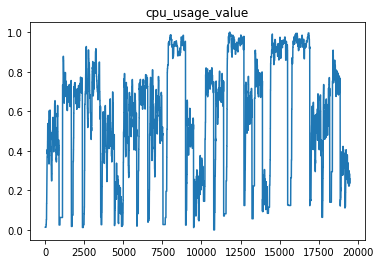

In [1509]:
plot_g(datasets_for_experiments[EXP_INDEX].scaled_dataset, "cpu_usage_value")

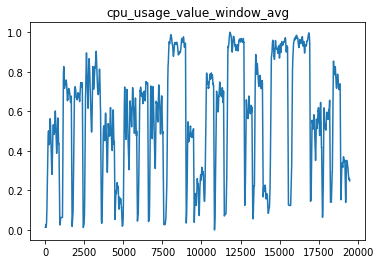

In [1510]:
plot_g(datasets_for_experiments[EXP_INDEX].scaled_dataset, "cpu_usage_value_window_avg")

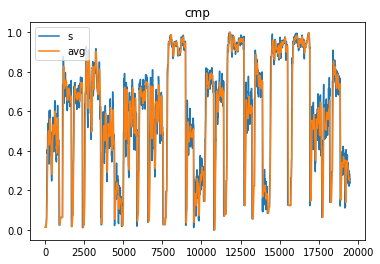

In [1511]:
plot2(list(range(datasets_for_experiments[EXP_INDEX].scaled_dataset.shape[0])), datasets_for_experiments[EXP_INDEX].scaled_dataset[["cpu_usage_value"]].to_numpy().squeeze(), datasets_for_experiments[EXP_INDEX].scaled_dataset[["cpu_usage_value_window_avg"]].to_numpy().squeeze(), "s", "avg", "cmp")

In [1512]:
bad_indices = np.array(list(range(len(datasets_for_experiments[EXP_INDEX].labels))))[datasets_for_experiments[EXP_INDEX].labels > THRESHOLD]
good_indices = np.array(list(range(len(datasets_for_experiments[EXP_INDEX].labels))))[datasets_for_experiments[EXP_INDEX].labels <= THRESHOLD]

In [1513]:
from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [1514]:
outliers_fraction = 0.25 #0.00663743
anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf",
                                      gamma=0.2)),
    ("Isolation Forest", IsolationForest(contamination=outliers_fraction,
                                         random_state=42)),
    ("Local Outlier Factor", LocalOutlierFactor(
        n_neighbors=6, contamination=outliers_fraction))]

In [1530]:
for name, algorithm in anomaly_algorithms:
    #X = datasets_for_experiments[0].scaled_dataset[["cpu_usage_value", "gpu_temp", "gpu_power_consumption", "gpu_utilization", "connections_count"]].to_numpy()
    a = ["cpu_usage_value", "gpu_temp", "gpu_power_consumption", "gpu_utilization", "connections_count"]
    a_w = ["cpu_usage_value_window_avg", "gpu_temp_window_avg", "gpu_power_consumption_window_avg", "gpu_utilization_window_avg", "connections_count_window_avg"]
    X = datasets_for_experiments[EXP_INDEX].scaled_dataset[a].to_numpy()
    labels = datasets_for_experiments[EXP_INDEX].labels
    X[good_indices] /= 1.3
    train_size = int(0.8*len(X))
    X_test = X[train_size:]
    X = X[:train_size]
    
    labels_test = labels[train_size:]
    labels = labels[:train_size]
    #algorithm.fit(X)

    # fit the data and tag outliers
    if name == "Local Outlier Factor":
        y_pred = algorithm.fit_predict(X)
    else:
        y_pred = algorithm.fit(X).predict(X)
    
    #print(y_pred)
    #print(datasets_for_experiments[0].labels[y_pred == -1])
    #print(datasets_for_experiments[0].scaled_dataset[["cpu_usage_value", "gpu_temp", "gpu_power_consumption", "gpu_utilization", "connections_count"]].to_numpy()[y_pred == -1])
    print(np.average(np.array(labels[y_pred == -1])))
    #print(f'true positive: {np.sum(np.array(datasets_for_experiments[EXP_INDEX].labels[y_pred == -1]) > THRESHOLD)}')
    #print(f'false positive: {np.sum(np.array(datasets_for_experiments[EXP_INDEX].labels[y_pred == -1]) <= THRESHOLD)}')
    
    #print(f'false negative: {np.sum(np.array(datasets_for_experiments[EXP_INDEX].labels[y_pred == 1]) > THRESHOLD)}')
    #print(f'true negative: {np.sum(np.array(datasets_for_experiments[EXP_INDEX].labels[y_pred == 1]) <= THRESHOLD)}')
    
    tp = np.sum(np.array(labels[y_pred == -1]) > THRESHOLD)
    fp = np.sum(np.array(labels[y_pred == -1]) <= THRESHOLD)
    fn = np.sum(np.array(labels[y_pred == 1]) > THRESHOLD)
    tn = np.sum(np.array(labels[y_pred == 1]) <= THRESHOLD)
    print(f'true positive: {tp}')
    print(f'false positive: {fp}')
    
    print(f'false negative: {fn}')
    print(f'true negative: {tn}')
    print(f'recall = {tp / (tp + fn)}')
    print(f'prec = {tp / (tp + fp)}')
    print(f'acc = {(tp+tn) / (tp + fp + tn + fn)}')
    print(f'f1 = {tp / (tp + 0.5*(fp + fn))}')
    print()
    
    if name == "Local Outlier Factor":
        continue
    else:
        y_pred = algorithm.predict(X_test)
        print()
        print("RESULTS FOR TTS SPLIT")
        tp = np.sum(np.array(labels_test[y_pred == -1]) > THRESHOLD)
        fp = np.sum(np.array(labels_test[y_pred == -1]) <= THRESHOLD)
        fn = np.sum(np.array(labels_test[y_pred == 1]) > THRESHOLD)
        tn = np.sum(np.array(labels_test[y_pred == 1]) <= THRESHOLD)
        print(f'true positive: {tp}')
        print(f'false positive: {fp}')

        print(f'false negative: {fn}')
        print(f'true negative: {tn}')
        print(f'recall = {tp / (tp + fn)}')
        print(f'prec = {tp / (tp + fp)}')
        print(f'acc = {(tp+tn) / (tp + fp + tn + fn)}')
        print(f'f1 = {tp / (tp + 0.5*(fp + fn))}')
        print("------------------------")
        print()
        print()

4687.801886792453
true positive: 1015
false positive: 2907
false negative: 2094
true negative: 9574
recall = 0.3264715342553876
prec = 0.258796532381438
acc = 0.6792174470814625
f1 = 0.2887213767600626


RESULTS FOR TTS SPLIT
true positive: 509
false positive: 690
false negative: 228
true negative: 2471
recall = 0.6906377204884667
prec = 0.4245204336947456
acc = 0.7644946126218574
f1 = 0.5258264462809917
------------------------


7870.415167095116
true positive: 1782
false positive: 2108
false negative: 1327
true negative: 10373
recall = 0.5731746542296559
prec = 0.45809768637532133
acc = 0.7796664528543938
f1 = 0.5092156022288898


RESULTS FOR TTS SPLIT
true positive: 541
false positive: 79
false negative: 196
true negative: 3082
recall = 0.7340569877883311
prec = 0.8725806451612903
acc = 0.9294510005130836
f1 = 0.7973470891672808
------------------------


8280.737166324436
true positive: 1825
false positive: 2071
false negative: 1284
true negative: 10410
recall = 0.5870054679961403

In [1532]:
for thresh in [0.75, 0.8, 0.85, 0.9, 0.95, 0.99]:
    #X = datasets_for_experiments[0].scaled_dataset[["cpu_usage_value", "gpu_temp", "gpu_power_consumption", "gpu_utilization", "connections_count"]].to_numpy()
    a = ["cpu_usage_value", "gpu_temp", "gpu_power_consumption", "gpu_utilization", "connections_count"]
    a_w = ["cpu_usage_value_window_avg", "gpu_temp_window_avg", "gpu_power_consumption_window_avg", "gpu_utilization_window_avg", "connections_count_window_avg"]
    X = datasets_for_experiments[EXP_INDEX].scaled_dataset[a].to_numpy()
    X[good_indices] /= 1.3
    train_size = int(0.8*len(X))
    X_max = X.max(axis=1)
    #print(X[100])
    #print(X_max[100])
    y_pred = X_max > thresh

    #print(y_pred)
    #print(datasets_for_experiments[0].labels[y_pred == -1])
    #print(datasets_for_experiments[0].scaled_dataset[["cpu_usage_value", "gpu_temp", "gpu_power_consumption", "gpu_utilization", "connections_count"]].to_numpy()[y_pred == -1])
    print(f'thresh = {thresh}')
    print(np.average(np.array(datasets_for_experiments[EXP_INDEX].labels[y_pred])))
    
    labels_all = datasets_for_experiments[EXP_INDEX].labels
    y_pred = y_pred[train_size:]
    #print(y_pred)
    labels = labels_all[train_size:]
    #print(labels)
    positives = np.array(labels[y_pred])
    negatives = np.array(labels[y_pred == False])
    #positives = positives[train_size:]
    #negatives = negatives[train_size:]
    tp = np.sum(positives > THRESHOLD)
    fp = np.sum(positives <= THRESHOLD)
    fn = np.sum(negatives > THRESHOLD)
    tn = np.sum(negatives <= THRESHOLD)
    print(f'true positive: {tp}')
    print(f'false positive: {fp}')
    
    print(f'false negative: {fn}')
    print(f'true negative: {tn}')
    print(f'recall = {tp / (tp + fn)}')
    print(f'prec = {tp / (tp + fp)}')
    print(f'acc = {(tp+tn) / (tp + fp + tn + fn)}')
    print(f'f1 = {tp / (tp + 0.5*(fp + fn))}')
    print()

thresh = 0.75
12454.708798338957
true positive: 551
false positive: 154
false negative: 186
true negative: 3007
recall = 0.7476255088195387
prec = 0.7815602836879433
acc = 0.9127757824525398
f1 = 0.7642163661581137

thresh = 0.8
16936.364430329497
true positive: 536
false positive: 0
false negative: 201
true negative: 3161
recall = 0.7272727272727273
prec = 1.0
acc = 0.9484350949204721
f1 = 0.8421052631578947

thresh = 0.85
16278.11836935167
true positive: 421
false positive: 0
false negative: 316
true negative: 3161
recall = 0.5712347354138398
prec = 1.0
acc = 0.9189327860441252
f1 = 0.7271157167530224

thresh = 0.9
15891.022072348253
true positive: 383
false positive: 0
false negative: 354
true negative: 3161
recall = 0.519674355495251
prec = 1.0
acc = 0.9091841970241149
f1 = 0.6839285714285714

thresh = 0.95
16235.750286368842
true positive: 236
false positive: 0
false negative: 501
true negative: 3161
recall = 0.3202170963364993
prec = 1.0
acc = 0.8714725500256542
f1 = 0.4850976361

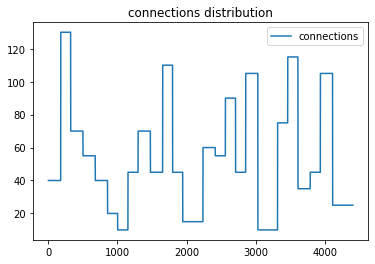

In [1498]:
plot(datasets_for_experiments[EXP_INDEX].timestamp_to_connections_X_axis, datasets_for_experiments[EXP_INDEX].timestamp_to_connections_Y_axis, "connections", "connections distribution")

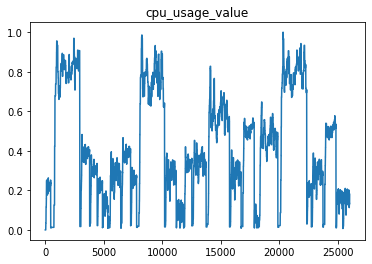

In [1499]:
plot_g(datasets_for_experiments[EXP_INDEX].scaled_dataset, "cpu_usage_value")

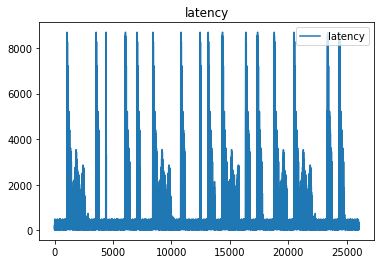

In [1500]:
plot(list(range(len(datasets_for_experiments[EXP_INDEX].labels))), datasets_for_experiments[EXP_INDEX].labels, "latency", "latency")

In [1461]:
len(bad_indices)

4343

In [1462]:
len(good_indices)

15145

In [1455]:
cpu_usage_for_bad_indices = datasets_for_experiments[EXP_INDEX].scaled_dataset[["cpu_usage_value"]].to_numpy()[bad_indices]
cpu_usage_for_good_indices = datasets_for_experiments[EXP_INDEX].scaled_dataset[["cpu_usage_value"]].to_numpy()[good_indices]
print(np.average(cpu_usage_for_bad_indices), np.average(cpu_usage_for_good_indices))
print(np.min(cpu_usage_for_bad_indices), np.max(cpu_usage_for_bad_indices))
print(np.min(cpu_usage_for_good_indices), np.max(cpu_usage_for_good_indices))

cpu_usage_for_bad_indices = datasets_for_experiments[EXP_INDEX].scaled_dataset[["cpu_usage_value_window_avg"]].to_numpy()[bad_indices]
cpu_usage_for_good_indices = datasets_for_experiments[EXP_INDEX].scaled_dataset[["cpu_usage_value_window_avg"]].to_numpy()[good_indices]
print(np.average(cpu_usage_for_bad_indices), np.average(cpu_usage_for_good_indices))
print(np.min(cpu_usage_for_bad_indices), np.max(cpu_usage_for_bad_indices))
print(np.min(cpu_usage_for_good_indices), np.max(cpu_usage_for_good_indices))

0.7262570277925502 0.5332758546746692
0.0 0.9999999999999999
0.0 0.9999999999999999
0.7322087215574898 0.5326284717130662
0.013499906480731377 0.9999194255501406
0.0 0.9999999999999999


In [1456]:
cpu_usage_for_bad_indices = datasets_for_experiments[EXP_INDEX].scaled_dataset[["gpu_temp"]].to_numpy()[bad_indices]
cpu_usage_for_good_indices = datasets_for_experiments[EXP_INDEX].scaled_dataset[["gpu_temp"]].to_numpy()[good_indices]
print(np.average(cpu_usage_for_bad_indices), np.average(cpu_usage_for_good_indices))

0.7279818098088878 0.6160696599537802


In [1374]:
datasets_for_experiments[EXP_INDEX].scaled_dataset

,normalize_partials,normalize_partials_window_avg,sample_rate,sample_rate_window_avg,channels_count,channels_count_window_avg,cpu_usage_value,cpu_usage_value_window_avg,mem_usage_in_gb,mem_usage_in_gb_window_avg,...,opened_files,opened_files_window_avg,read_ops,read_ops_window_avg,write_ops,write_ops_window_avg,read_bytes,read_bytes_window_avg,write_bytes,write_bytes_window_avg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.032487,0.029803,0.389157,0.346196,...,0.911290,0.556174,0.0,0.0,0.00436,0.035461,0.0,0.0,0.001333,0.033230
1,0.0,0.0,0.0,0.0,0.0,0.0,0.032487,0.029803,0.389157,0.346196,...,0.911290,0.556174,0.0,0.0,0.00436,0.035461,0.0,0.0,0.001333,0.033230
2,0.0,0.0,0.0,0.0,0.0,0.0,0.032487,0.029803,0.389157,0.346196,...,0.911290,0.556174,0.0,0.0,0.00436,0.035461,0.0,0.0,0.001333,0.033230
3,0.0,0.0,0.0,0.0,0.0,0.0,0.032487,0.029803,0.389157,0.346196,...,0.911290,0.556174,0.0,0.0,0.00436,0.035461,0.0,0.0,0.001333,0.033230
4,0.0,0.0,0.0,0.0,0.0,0.0,0.032487,0.029803,0.389157,0.346196,...,0.911290,0.556174,0.0,0.0,0.00436,0.035461,0.0,0.0,0.001333,0.033230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16869,0.0,0.0,1.0,1.0,0.0,0.0,0.279163,0.227497,0.683906,0.670065,...,0.919355,0.612903,0.0,0.0,0.00000,0.004728,0.0,0.0,0.000000,0.001772
16870,0.0,0.0,1.0,1.0,0.0,0.0,0.279163,0.227214,0.683906,0.670031,...,0.919355,0.612903,0.0,0.0,0.00000,0.004728,0.0,0.0,0.000000,0.001772
16871,0.0,0.0,1.0,1.0,0.0,0.0,0.279163,0.226930,0.683906,0.669997,...,0.919355,0.612903,0.0,0.0,0.00000,0.004492,0.0,0.0,0.000000,0.001728
16872,0.0,0.0,1.0,1.0,0.0,0.0,0.286134,0.226789,0.683247,0.669949,...,0.927419,0.614016,0.0,0.0,0.00000,0.004492,0.0,0.0,0.000000,0.001728


In [1535]:
datasets_for_experiments[EXP_INDEX].labels

array([ 66.,  47., 584., ..., 252., 199., 111.])

In [1534]:
datasets_for_experiments[EXP_INDEX].labels

array([ 66.,  47., 584., ..., 252., 199., 111.])

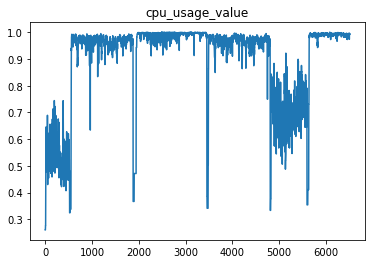

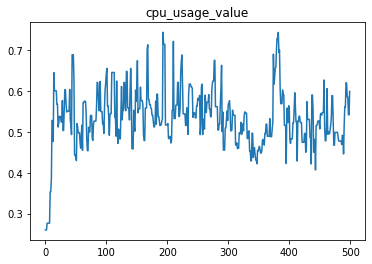

In [874]:
plot_g(df, "cpu_usage_value", 500)

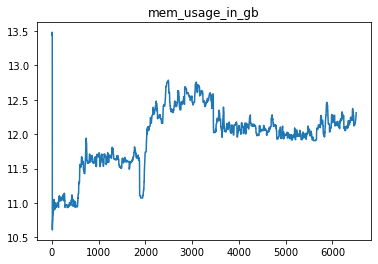

In [875]:
plot_g(df, "mem_usage_in_gb")

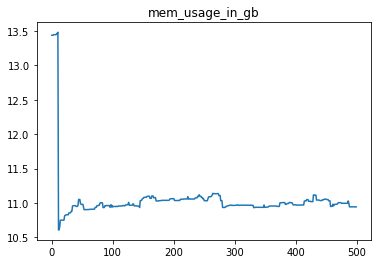

In [876]:
plot_g(df, "mem_usage_in_gb", 500)

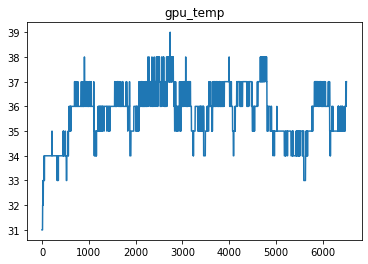

In [877]:
plot_g(df, "gpu_temp")

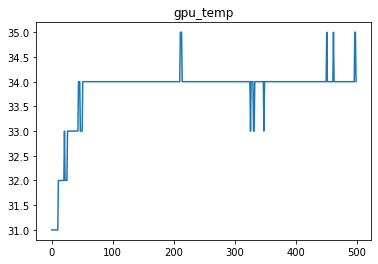

In [878]:
plot_g(df, "gpu_temp", 500)

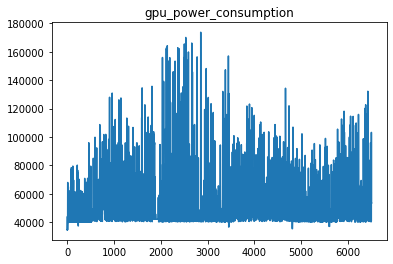

In [879]:
plot_g(df, "gpu_power_consumption")

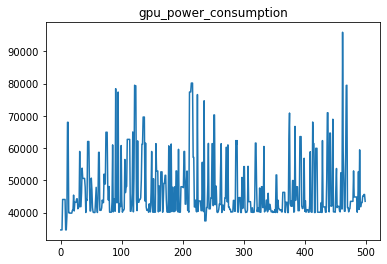

In [880]:
plot_g(df, "gpu_power_consumption", 500)

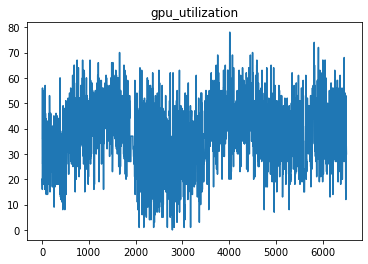

In [881]:
plot_g(df, "gpu_utilization")

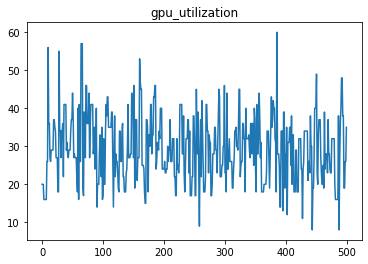

In [882]:
plot_g(df, "gpu_utilization", 500)

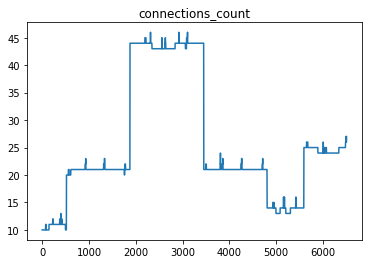

In [883]:
plot_g(df, "connections_count")

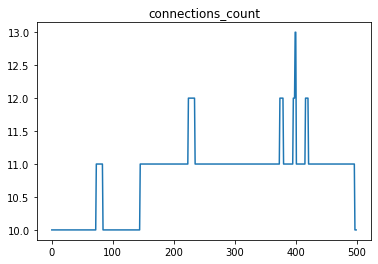

In [884]:
plot_g(df, "connections_count", 500)

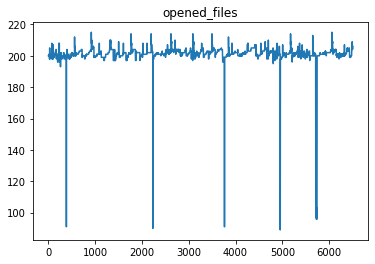

In [885]:
plot_g(df, "opened_files")

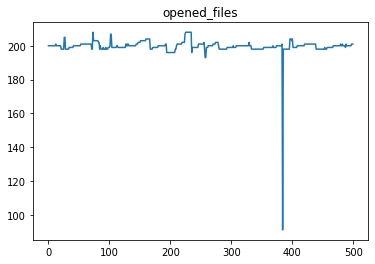

In [886]:
plot_g(df, "opened_files", 500)

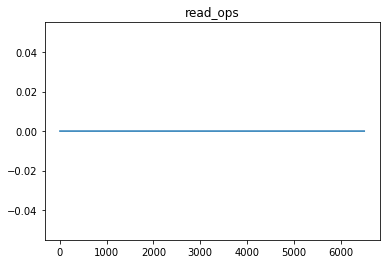

In [887]:
plot_g(df, "read_ops")

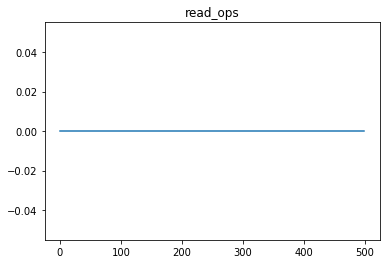

In [888]:
plot_g(df, "read_ops", 500)

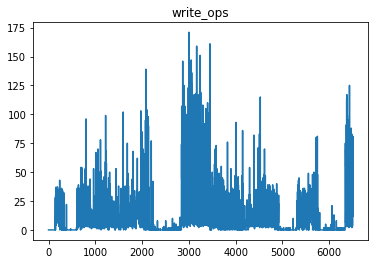

In [889]:
plot_g(df, "write_ops")

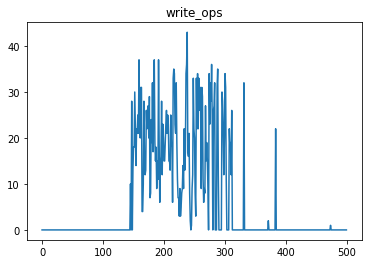

In [890]:
plot_g(df, "write_ops", 500)

In [891]:

x = df.to_numpy()
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_scaled = pd.DataFrame(x_scaled)

In [892]:
print(df_scaled)

        0    1    2         3         4        5         6      7         8  \
0     0.0  0.0  0.0  0.000000  0.984773  0.00000  0.000000  0.000  0.000000   
1     0.0  0.0  0.0  0.000000  0.984773  0.00000  0.000000  0.000  0.000000   
2     0.0  0.0  0.0  0.000000  0.984773  0.00000  0.000000  0.000  0.000000   
3     0.0  0.0  0.0  0.022270  0.987686  0.01595  0.020941  0.000  0.067918   
4     0.0  0.0  0.0  0.022270  0.987686  0.01595  0.020941  0.000  0.067918   
...   ...  ...  ...       ...       ...      ...       ...    ...       ...   
6502  0.0  0.0  0.0  0.986098  0.572189  1.00000  1.000000  0.625  0.045519   
6503  0.0  0.0  0.0  0.992413  0.580327  1.00000  1.000000  0.750  0.493315   
6504  0.0  0.0  0.0  0.991116  0.592766  1.00000  1.000000  0.750  0.135341   
6505  0.0  0.0  0.0  0.991116  0.592766  1.00000  1.000000  0.750  0.135341   
6506  0.0  0.0  0.0  0.991116  0.592766  1.00000  1.000000  0.750  0.135341   

             9        10        11   12        13  

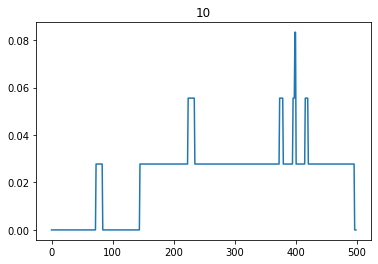

In [893]:
plot_g(df_scaled, 10, 500)

In [894]:
print(df_scaled)

        0    1    2         3         4        5         6      7         8  \
0     0.0  0.0  0.0  0.000000  0.984773  0.00000  0.000000  0.000  0.000000   
1     0.0  0.0  0.0  0.000000  0.984773  0.00000  0.000000  0.000  0.000000   
2     0.0  0.0  0.0  0.000000  0.984773  0.00000  0.000000  0.000  0.000000   
3     0.0  0.0  0.0  0.022270  0.987686  0.01595  0.020941  0.000  0.067918   
4     0.0  0.0  0.0  0.022270  0.987686  0.01595  0.020941  0.000  0.067918   
...   ...  ...  ...       ...       ...      ...       ...    ...       ...   
6502  0.0  0.0  0.0  0.986098  0.572189  1.00000  1.000000  0.625  0.045519   
6503  0.0  0.0  0.0  0.992413  0.580327  1.00000  1.000000  0.750  0.493315   
6504  0.0  0.0  0.0  0.991116  0.592766  1.00000  1.000000  0.750  0.135341   
6505  0.0  0.0  0.0  0.991116  0.592766  1.00000  1.000000  0.750  0.135341   
6506  0.0  0.0  0.0  0.991116  0.592766  1.00000  1.000000  0.750  0.135341   

             9        10        11   12        13  

In [895]:
train_size = int(0.8 * len(df))

In [896]:
df_scaled[3] = df_scaled[3].shift(-1)

In [897]:
print(df_scaled)

        0    1    2         3         4        5         6      7         8  \
0     0.0  0.0  0.0  0.000000  0.984773  0.00000  0.000000  0.000  0.000000   
1     0.0  0.0  0.0  0.000000  0.984773  0.00000  0.000000  0.000  0.000000   
2     0.0  0.0  0.0  0.022270  0.984773  0.00000  0.000000  0.000  0.000000   
3     0.0  0.0  0.0  0.022270  0.987686  0.01595  0.020941  0.000  0.067918   
4     0.0  0.0  0.0  0.022270  0.987686  0.01595  0.020941  0.000  0.067918   
...   ...  ...  ...       ...       ...      ...       ...    ...       ...   
6502  0.0  0.0  0.0  0.992413  0.572189  1.00000  1.000000  0.625  0.045519   
6503  0.0  0.0  0.0  0.991116  0.580327  1.00000  1.000000  0.750  0.493315   
6504  0.0  0.0  0.0  0.991116  0.592766  1.00000  1.000000  0.750  0.135341   
6505  0.0  0.0  0.0  0.991116  0.592766  1.00000  1.000000  0.750  0.135341   
6506  0.0  0.0  0.0       NaN  0.592766  1.00000  1.000000  0.750  0.135341   

             9        10        11   12        13  

In [898]:
df_scaled[3][len(df_scaled)-1] = df_scaled[3][len(df_scaled)-2]

In [899]:
print(df_scaled)

        0    1    2         3         4        5         6      7         8  \
0     0.0  0.0  0.0  0.000000  0.984773  0.00000  0.000000  0.000  0.000000   
1     0.0  0.0  0.0  0.000000  0.984773  0.00000  0.000000  0.000  0.000000   
2     0.0  0.0  0.0  0.022270  0.984773  0.00000  0.000000  0.000  0.000000   
3     0.0  0.0  0.0  0.022270  0.987686  0.01595  0.020941  0.000  0.067918   
4     0.0  0.0  0.0  0.022270  0.987686  0.01595  0.020941  0.000  0.067918   
...   ...  ...  ...       ...       ...      ...       ...    ...       ...   
6502  0.0  0.0  0.0  0.992413  0.572189  1.00000  1.000000  0.625  0.045519   
6503  0.0  0.0  0.0  0.991116  0.580327  1.00000  1.000000  0.750  0.493315   
6504  0.0  0.0  0.0  0.991116  0.592766  1.00000  1.000000  0.750  0.135341   
6505  0.0  0.0  0.0  0.991116  0.592766  1.00000  1.000000  0.750  0.135341   
6506  0.0  0.0  0.0  0.991116  0.592766  1.00000  1.000000  0.750  0.135341   

             9        10        11   12        13  

In [900]:
print(df_scaled)

        0    1    2         3         4        5         6      7         8  \
0     0.0  0.0  0.0  0.000000  0.984773  0.00000  0.000000  0.000  0.000000   
1     0.0  0.0  0.0  0.000000  0.984773  0.00000  0.000000  0.000  0.000000   
2     0.0  0.0  0.0  0.022270  0.984773  0.00000  0.000000  0.000  0.000000   
3     0.0  0.0  0.0  0.022270  0.987686  0.01595  0.020941  0.000  0.067918   
4     0.0  0.0  0.0  0.022270  0.987686  0.01595  0.020941  0.000  0.067918   
...   ...  ...  ...       ...       ...      ...       ...    ...       ...   
6502  0.0  0.0  0.0  0.992413  0.572189  1.00000  1.000000  0.625  0.045519   
6503  0.0  0.0  0.0  0.991116  0.580327  1.00000  1.000000  0.750  0.493315   
6504  0.0  0.0  0.0  0.991116  0.592766  1.00000  1.000000  0.750  0.135341   
6505  0.0  0.0  0.0  0.991116  0.592766  1.00000  1.000000  0.750  0.135341   
6506  0.0  0.0  0.0  0.991116  0.592766  1.00000  1.000000  0.750  0.135341   

             9        10        11   12        13  

In [901]:
df_scaled_train, df_scaled_test = df_scaled[:train_size], df_scaled[train_size:]

In [902]:
X_train, y_train = df_scaled_train.drop([3], axis=1).to_numpy(), df_scaled_train[3].to_numpy()

In [903]:
print(X_train, y_train)

[[0.         0.         0.         ... 0.         0.         0.00059523]
 [0.         0.         0.         ... 0.         0.         0.17919281]
 [0.         0.         0.         ... 0.         0.         0.006356  ]
 ...
 [0.         0.         0.         ... 0.         0.         0.20967974]
 [0.         0.         0.         ... 0.         0.         0.00892167]
 [0.         0.         0.         ... 0.         0.         0.4023782 ]] [0.         0.         0.02226977 ... 0.52947474 0.58718069 0.56321325]


In [904]:
X_test, y_test = df_scaled_test.drop([3], axis=1).to_numpy(), df_scaled_test[3].to_numpy()

In [905]:
print(X_test, y_test)

[[0.         0.         0.         ... 0.         0.         0.00888062]
 [0.         0.         0.         ... 0.         0.         0.01457981]
 [0.         0.         0.         ... 0.         0.         0.40268608]
 ...
 [0.         0.         0.         ... 0.         0.01236014 0.00097837]
 [0.         0.         0.         ... 0.         0.01821494 0.00513817]
 [0.         0.         0.         ... 0.         0.00312256 0.00773804]] [0.54731515 0.50109821 0.50109821 ... 0.99111561 0.99111561 0.99111561]


In [906]:

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

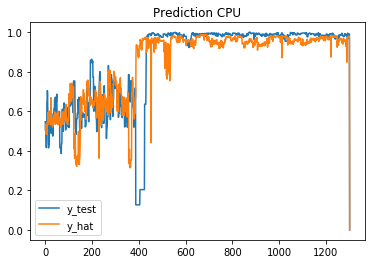

In [907]:
plt.clf()
x, yt, yh = list(range(len(y_test))), list(y_test), list(y_hat)   
x.append(len(x))
yt.append(0)
yh.append(0)
plt.plot(x, yt, label="y_test")
plt.plot(x, yh, label="y_hat")
plt.title("Prediction CPU")
plt.legend()
plt.show()


In [908]:
print(model.score(X_test, y_test))

0.47432571361140796


Index(['normalize_partials', 'sample_rate', 'channels_count',
       'mem_usage_in_gb', 'gpu_avg_mem_usage', 'gpu_max_mem_usage', 'gpu_temp',
       'gpu_power_consumption', 'gpu_utilization', 'connections_count',
       'opened_files', 'read_ops', 'write_ops', 'read_bytes', 'write_bytes',
       'label'],
      dtype='object')
Index(['connections_count', 'mem_usage_in_gb', 'opened_files',
       'gpu_avg_mem_usage', 'gpu_max_mem_usage'],
      dtype='object')
[0.67879012 0.13667205 0.03501613 0.03371969 0.03328086]


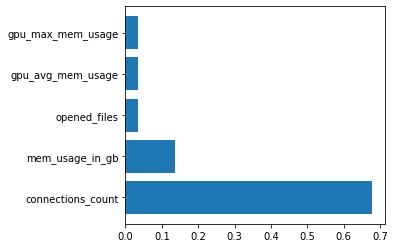

In [909]:
importances = model.feature_importances_
ind = np.argsort(importances)[::-1]
keys = df.drop(["cpu_usage_value"], axis=1).keys()
print(keys)
print(keys[ind[:5]])
print(importances[ind[:5]])
plt.clf()
plt.gcf().subplots_adjust(left=0.3)
plt.barh(range(len(keys[ind[:5]])), importances[ind[:5]], align='center')
plt.yticks(range(len(keys[ind[:5]])), keys[ind[:5]])
plt.show()

In [910]:

samples_weight_train = []
n = len(X_train)
for i in range(len(X_train)):
    samples_weight_train.append(math.exp((4.0 / n) * i))

print(samples_weight_train[:10])

[1.0, 1.0007687872002815, 1.0015381654343223, 1.0023081351565015, 1.0030786968215477, 1.0038498508845393, 1.0046215978009037, 1.0053939380264194, 1.0061668720172146, 1.0069404002297686]


In [911]:
from sklearn.ensemble import RandomForestRegressor
model2 = RandomForestRegressor(random_state=42)
model2.fit(X_train, y_train, sample_weight=samples_weight_train)
y_hat = model2.predict(X_test)

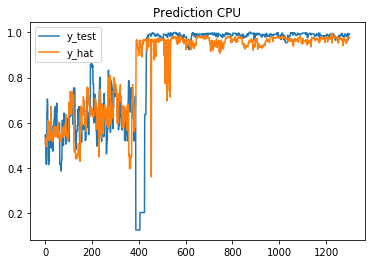

In [912]:
plt.clf()
x, yt, yh = list(range(len(y_test))), list(y_test), list(y_hat)   
plt.plot(x, yt, label="y_test")
plt.plot(x, yh, label="y_hat")
plt.title("Prediction CPU")
plt.legend()
plt.show()

In [913]:
print(model2.score(X_test, y_test))

0.4967493885404096


Index(['normalize_partials', 'sample_rate', 'channels_count',
       'mem_usage_in_gb', 'gpu_avg_mem_usage', 'gpu_max_mem_usage', 'gpu_temp',
       'gpu_power_consumption', 'gpu_utilization', 'connections_count',
       'opened_files', 'read_ops', 'write_ops', 'read_bytes', 'write_bytes',
       'label'],
      dtype='object')
Index(['connections_count', 'mem_usage_in_gb', 'gpu_temp', 'opened_files',
       'gpu_utilization'],
      dtype='object')
[0.70171289 0.10902566 0.06871045 0.04709947 0.02290013]


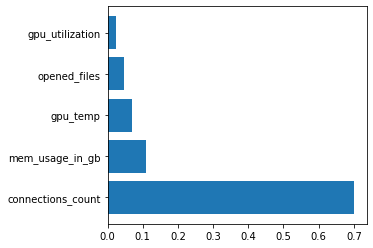

In [914]:
importances = model2.feature_importances_
ind = np.argsort(importances)[::-1]
keys = df.drop(["cpu_usage_value"], axis=1).keys()
print(keys)
print(keys[ind[:5]])
print(importances[ind[:5]])
plt.clf()
plt.gcf().subplots_adjust(left=0.3)
plt.barh(range(len(keys[ind[:5]])), importances[ind[:5]], align='center')
plt.yticks(range(len(keys[ind[:5]])), keys[ind[:5]])
plt.show()

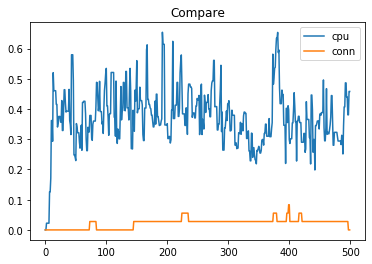

In [915]:
plt.clf()
x, yt, yh = list(range(len(df_scaled))), list(df_scaled[3]), list(df_scaled[10])
nn = 500
x, yt, yh = x[:nn], yt[:nn], yh[:nn]
plt.plot(x, yt, label="cpu")
plt.plot(x, yh, label="conn")
plt.title("Compare")
plt.legend()
plt.show()

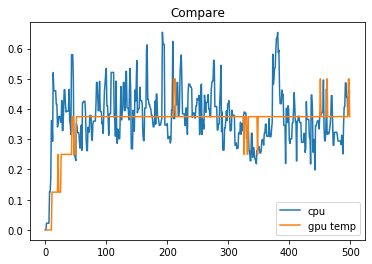

In [916]:
plt.clf()
x, yt, yh = list(range(len(df_scaled))), list(df_scaled[3]), list(df_scaled[7])
nn = 500
x, yt, yh = x[:nn], yt[:nn], yh[:nn]
plt.plot(x, yt, label="cpu")
plt.plot(x, yh, label="gpu temp")
plt.title("Compare")
plt.legend()
plt.show()

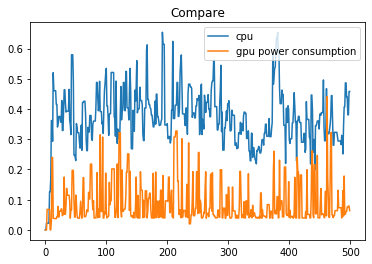

In [917]:
plt.clf()
x, yt, yh = list(range(len(df_scaled))), list(df_scaled[3]), list(df_scaled[8])
nn = 500
x, yt, yh = x[:nn], yt[:nn], yh[:nn]
plt.plot(x, yt, label="cpu")
plt.plot(x, yh, label="gpu power consumption")
plt.title("Compare")
plt.legend()
plt.show()

In [919]:
orig_keys = list(df.keys())
l = []
for i in range(len(df_scaled.keys())):
    if i != 3:
        l.append({"matric": orig_keys[i], "corr": spearmanr(list(df_scaled[3]), list(df_scaled[i]))})

/home/jupyter/work/pyenv/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [920]:
ddf = pd.DataFrame(l)
print(ddf)

                   matric                                           corr
0      normalize_partials                                     (nan, nan)
1             sample_rate                                     (nan, nan)
2          channels_count                                     (nan, nan)
3         mem_usage_in_gb                      (0.6557849659252212, 0.0)
4       gpu_avg_mem_usage   (0.3491166355875369, 7.192939847129206e-186)
5       gpu_max_mem_usage  (0.34898991853879646, 9.985200595746567e-186)
6                gpu_temp   (0.4327623221796205, 2.729497687534847e-295)
7   gpu_power_consumption   (0.09739505932119251, 3.443520405944934e-15)
8         gpu_utilization  (-0.030875469205197698, 0.012748626539257733)
9       connections_count                       (0.769889590421463, 0.0)
10           opened_files   (0.17336027587871666, 4.476741477851697e-45)
11               read_ops                                     (nan, nan)
12              write_ops    (0.05506864512610083, 

In [921]:
def load_stress_test_log(log_path):
    timestamp_to_timing = {}
    timestamp_to_connections = {}
    cur_connections = 0
    time_first = None
    time_last = None
    with open(log_path, 'r') as log_file:
        for log_line in log_file.readlines():
            parts = log_line.split()
            ts = " ".join([parts[1], parts[2]])
            ts = datetime.datetime.strptime(ts, '%Y-%m-%d %H:%M:%S.%f')
            if time_first is None: 
                time_first = ts
                
            time_last = ts
            if parts[0] == "WARNING":
                cur_connections = int(parts[5].split("=")[1])
                #timestamp_to_connections[ts] = cur_connections
            elif parts[0] == "INFO:" and parts[5] == "STATS":
                timing = int(parts[6])
                timestamp_to_connections[ts] = cur_connections
                timestamp_to_timing[ts] = timing
    
    
    
    return timestamp_to_timing, timestamp_to_connections, time_first, time_last

In [922]:
timestamp_to_timing, timestamp_to_connections, time_first, time_last = load_stress_test_log(stress_test_log_path)

In [923]:
timestamp_to_timing_X_axis = list(map(lambda ts: (ts - time_first).total_seconds(), list(timestamp_to_timing.keys())))

In [924]:
timestamp_to_timing_Y_axis = list(timestamp_to_timing.values())

In [925]:
def plot(x, y, l, title):
    plt.clf()
    plt.plot(x, y, label=l)
    plt.title(title)
    plt.legend()
    plt.show()

In [926]:
def plot2(x, y1, y2, l1, l2, title):
    plt.clf()
    plt.plot(x, y1, label=l1)
    plt.plot(x, y2, label=l2)
    plt.title(title)
    plt.legend()
    plt.show()

In [927]:
def plot_arr(x, ys, ls, title):
    plt.clf()
    for yi, li in zip(ys, ls):
        plt.plot(x, yi, label=li)
    plt.title(title)
    plt.legend()
    plt.show()

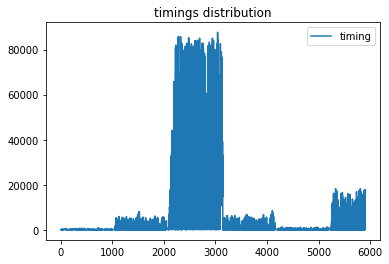

In [928]:
plot(timestamp_to_timing_X_axis, timestamp_to_timing_Y_axis, "timing", "timings distribution")

In [929]:
timestamp_to_connections_X_axis = list(map(lambda ts: (ts - time_first).total_seconds(), list(timestamp_to_connections.keys())))
timestamp_to_connections_Y_axis = list(timestamp_to_connections.values())

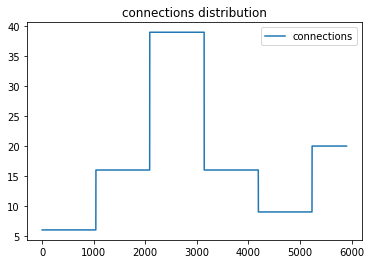

In [930]:
plot(timestamp_to_connections_X_axis, timestamp_to_connections_Y_axis, "connections", "connections distribution")

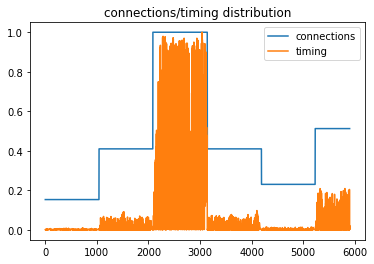

In [931]:
plot2(timestamp_to_connections_X_axis,
      list(np.array(timestamp_to_connections_Y_axis, dtype=np.float32) / max(timestamp_to_connections_Y_axis)),
      list(np.array(timestamp_to_timing_Y_axis, dtype=np.float32) / max(timestamp_to_timing_Y_axis)),
      "connections",
      "timing",
      "connections/timing distribution")

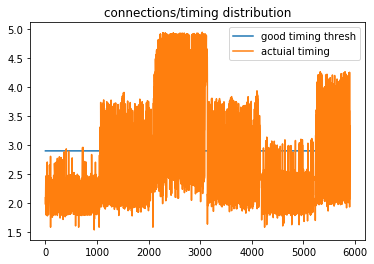

In [932]:
plot2(timestamp_to_connections_X_axis,
      [np.log10(800.0)] * len(timestamp_to_connections_X_axis),
      list(map(lambda t: np.log10(t), timestamp_to_timing_Y_axis)),
      "good timing thresh",
      "actuial timing",
      "connections/timing distribution")

In [933]:
df = pd.DataFrame(dataset)

In [934]:

x = df.to_numpy()
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_scaled = pd.DataFrame(x_scaled)

In [935]:
df_scaled_h = df_scaled.drop([0, 1, 2, 16], axis=1)

In [936]:
df_scaled_h

,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.000000,0.984773,0.00000,0.000000,0.000,0.000000,0.256410,0.000000,0.880952,0.0,0.000000,0.0,0.000000
1,0.000000,0.984773,0.00000,0.000000,0.000,0.000000,0.256410,0.000000,0.880952,0.0,0.000000,0.0,0.000000
2,0.000000,0.984773,0.00000,0.000000,0.000,0.000000,0.256410,0.000000,0.880952,0.0,0.000000,0.0,0.000000
3,0.022270,0.987686,0.01595,0.020941,0.000,0.067918,0.205128,0.000000,0.880952,0.0,0.000000,0.0,0.000000
4,0.022270,0.987686,0.01595,0.020941,0.000,0.067918,0.205128,0.000000,0.880952,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6502,0.986098,0.572189,1.00000,1.000000,0.625,0.045519,0.397436,0.444444,0.920635,0.0,0.134503,0.0,0.005595
6503,0.992413,0.580327,1.00000,1.000000,0.750,0.493315,0.423077,0.444444,0.920635,0.0,0.157895,0.0,0.006375
6504,0.991116,0.592766,1.00000,1.000000,0.750,0.135341,0.384615,0.444444,0.920635,0.0,0.309942,0.0,0.012360
6505,0.991116,0.592766,1.00000,1.000000,0.750,0.135341,0.384615,0.444444,0.920635,0.0,0.473684,0.0,0.018215


In [937]:
class HardwareVectorModel:
    def __init__(self, df_scaled, train_size):
        self.df_scaled = df_scaled
        self.train_size = train_size
        self.df_scaled_train, self.df_scaled_test = df_scaled[:train_size], df_scaled[train_size:]
        self.models = []
        print(f'Total features: {len(self.df_scaled.keys())}')
        
    def fit(self):
        for feature_to_predict_index in range(len(self.df_scaled.keys())):
            print(f'Train model for feature {feature_to_predict_index}!')
            model = RandomForestRegressor(random_state=42)
            shifted_idx = feature_to_predict_index + 3
            X_train, y_train = self.df_scaled_train.drop([shifted_idx], axis=1).to_numpy(), self.df_scaled_train[shifted_idx]
            #print(X_train.shape, y_train.shape)
            y_train = y_train.shift(-1)
            y_train[len(y_train) - 1] = y_train[len(y_train) - 2]
            y_train = y_train.to_numpy()
            model.fit(X_train, y_train)
            self.models.append(model)
    
    def predict(self, X):
        result = []
        for i, model_i in enumerate(self.models):
            prediction = model_i.predict(np.delete(X, [i]).reshape(1, -1))
            result.append(prediction)
        
        return np.array(result)
    
    def predict_batch(self, X):
        result = []
        for i, model_i in enumerate(self.models):
            prediction = model_i.predict(np.delete(X, [i], axis=1))
            result.append(prediction)
        
        return np.vstack(result)
    
    def get_test(self):
        return self.df_scaled_test

In [938]:
hvm = HardwareVectorModel(df_scaled_h, int(0.8 * len(df_scaled_h)))

Total features: 13


In [939]:
hvm.fit()

Train model for feature 0!
Train model for feature 1!
Train model for feature 2!
Train model for feature 3!
Train model for feature 4!
Train model for feature 5!
Train model for feature 6!
Train model for feature 7!
Train model for feature 8!
Train model for feature 9!
Train model for feature 10!
Train model for feature 11!
Train model for feature 12!


In [940]:
X_test = hvm.get_test().to_numpy()

In [941]:
X_test.shape

(1302, 13)

In [942]:
predictions = hvm.predict_batch(X_test)

In [943]:
predictions = predictions.swapaxes(0, 1)

In [944]:
X_test_with_preds = X_test[1:]
Preds_with_x_test = predictions[:-1]

In [945]:
def plot_feature(i, names):
    d1 = X_test_with_preds[:, i]
    d2 = Preds_with_x_test[:, i]
    plot2(list(range(len(d1))), d1, d2, "actual", "predicted", names[i])

In [946]:
keys = list(df.keys())[3:]

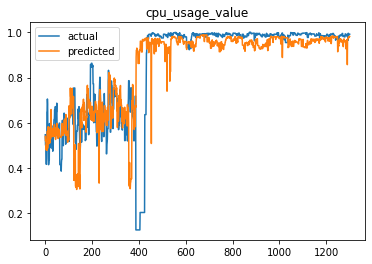

In [947]:
plot_feature(0, keys)

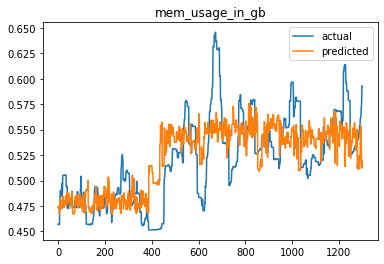

In [948]:
plot_feature(1, keys)

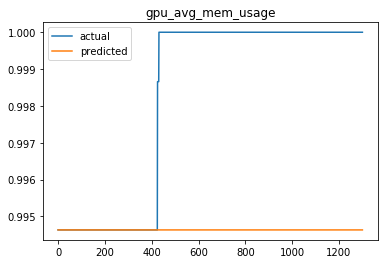

In [949]:
plot_feature(2, keys)

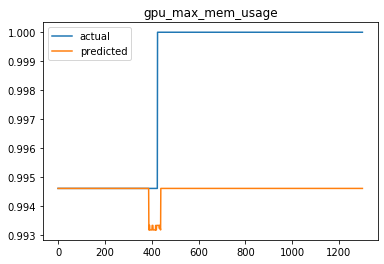

In [950]:
plot_feature(3, keys)

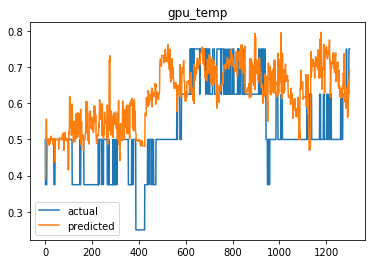

In [951]:
plot_feature(4, keys)

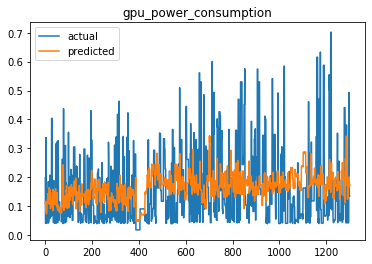

In [952]:
plot_feature(5, keys)

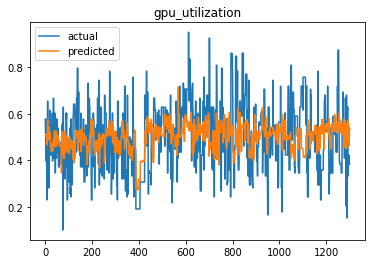

In [953]:
plot_feature(6, keys)

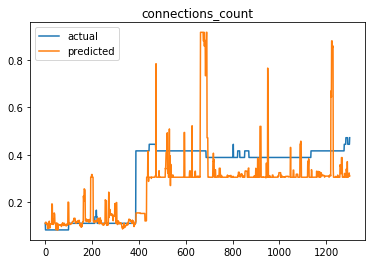

In [954]:
plot_feature(7, keys)

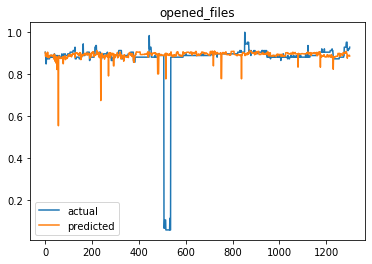

In [955]:
plot_feature(8, keys)

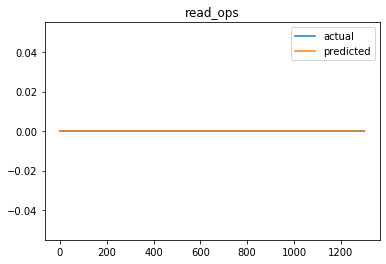

In [956]:
plot_feature(9, keys)

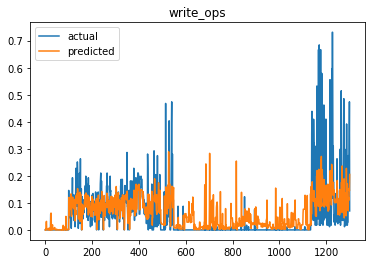

In [957]:
plot_feature(10, keys)

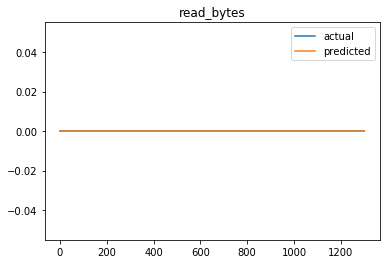

In [958]:
plot_feature(11, keys)

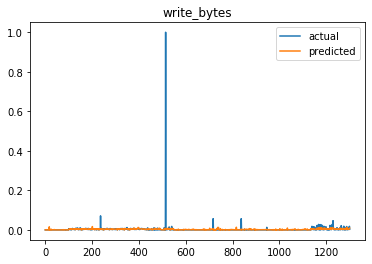

In [959]:
plot_feature(12, keys)

In [960]:
dataset_dicts = {}

labels_hardware = []
dataset_hardware = []
keys_hardware = []
for _, h, conn in session_hardware_pairs:
    features_vec = {**h.to_features_dict(), **conn.to_features_dict()}
    ts = max(h.key(), conn.key())
    keys_hardware.append(ts)
    dataset_hardware.append(features_vec)

In [961]:
dataset_pairs = []

In [962]:
for k, v in timestamp_to_timing.items():
    i = bisect.bisect_left(keys_hardware, k, lo=0, hi=len(keys_hardware) - 1)
    dataset_pairs.append((dataset_hardware[i], v))

In [963]:
df_hardware_vectors = pd.DataFrame(list(map(lambda t: {**t[0], **{"label": t[1]}}, dataset_pairs)))

In [964]:

x = df_hardware_vectors.to_numpy()
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_hardware_vectors_scaled = pd.DataFrame(x_scaled)

In [965]:
df_hardware_vectors_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.000000,0.984773,0.000000,0.000000,0.000,0.000000,0.256410,0.000000,0.880,0.0,0.000000,0.0,0.000000,0.001027
1,0.022270,0.987686,0.015950,0.020941,0.000,0.067918,0.205128,0.000000,0.880,0.0,0.000000,0.0,0.000000,0.000776
2,0.126155,0.993272,0.039659,0.042459,0.000,0.000079,0.333333,0.000000,0.880,0.0,0.000000,0.0,0.000000,0.000924
3,0.171059,1.000000,0.060925,0.068972,0.000,0.030523,0.717949,0.000000,0.880,0.0,0.000000,0.0,0.000000,0.000696
4,0.362001,0.000000,0.201504,0.206148,0.125,0.240051,0.461538,0.000000,0.880,0.0,0.000000,0.0,0.000000,0.002556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6477,0.991116,0.592766,1.000000,1.000000,0.750,0.135341,0.384615,0.472222,0.928,0.0,0.070175,0.0,0.023346,0.001438
6478,0.991116,0.592766,1.000000,1.000000,0.750,0.135341,0.384615,0.472222,0.928,0.0,0.070175,0.0,0.023346,0.000593
6479,0.991116,0.592766,1.000000,1.000000,0.750,0.135341,0.384615,0.472222,0.928,0.0,0.070175,0.0,0.023346,0.022334
6480,0.991116,0.592766,1.000000,1.000000,0.750,0.135341,0.384615,0.472222,0.928,0.0,0.070175,0.0,0.023346,0.015988


In [966]:
train_size = int(0.8 * len(df_hardware_vectors_scaled))

In [967]:
df_hardware_vectors_scaled_train, df_hardware_vectors_scaled_test = df_hardware_vectors_scaled[:train_size], df_hardware_vectors_scaled[train_size:]

In [968]:
df_hardware_vectors_scaled_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.000000,0.984773,0.000000,0.000000,0.000,0.000000,0.256410,0.000000,0.880,0.0,0.0,0.0,0.0,0.001027
1,0.022270,0.987686,0.015950,0.020941,0.000,0.067918,0.205128,0.000000,0.880,0.0,0.0,0.0,0.0,0.000776
2,0.126155,0.993272,0.039659,0.042459,0.000,0.000079,0.333333,0.000000,0.880,0.0,0.0,0.0,0.0,0.000924
3,0.171059,1.000000,0.060925,0.068972,0.000,0.030523,0.717949,0.000000,0.880,0.0,0.0,0.0,0.0,0.000696
4,0.362001,0.000000,0.201504,0.206148,0.125,0.240051,0.461538,0.000000,0.880,0.0,0.0,0.0,0.0,0.002556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5180,0.658279,0.472632,0.994636,0.994621,0.375,0.133644,0.435897,0.083333,0.880,0.0,0.0,0.0,0.0,0.001244
5181,0.617625,0.473241,0.994636,0.994621,0.375,0.040947,0.602564,0.083333,0.880,0.0,0.0,0.0,0.0,0.003150
5182,0.615960,0.472700,0.994636,0.994621,0.500,0.060277,0.576923,0.083333,0.880,0.0,0.0,0.0,0.0,0.003618
5183,0.671621,0.473062,0.994636,0.994621,0.500,0.074863,0.346154,0.083333,0.880,0.0,0.0,0.0,0.0,0.000342


In [1536]:
X, y = datasets_for_experiments[EXP_INDEX].scaled_dataset.to_numpy(), datasets_for_experiments[EXP_INDEX].labels
train_size = int(0.8 * len(X))
X_train, y_train = X[train_size:], y[train_size:]
X_test, y_test = X[train_size:], y[train_size:]

In [1558]:
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.linear_model import *

"""
GradientBoostingRegressor
LinearRegression
BaggingRegressor
DecisionTreeRegressor
PassiveAggressiveRegressor
HuberRegressor
"""

'\nGradientBoostingRegressor\nLinearRegression\nBaggingRegressor\nDecisionTreeRegressor\nPassiveAggressiveRegressor\nHuberRegressor\n'

In [1565]:
model_predict_latency = HuberRegressor()
model_predict_latency.fit(X_train, y_train)
model_predict_latency.score(X_test, y_test)

/home/jupyter/work/pyenv/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


-0.13563084905067457

In [1540]:
prediction_latency = model_predict_latency.predict(X_test)

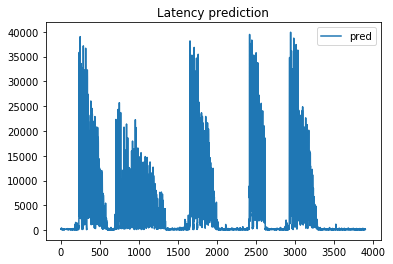

In [1549]:
plot(list(range(len(prediction_latency))), prediction_latency, "pred", "Latency prediction")

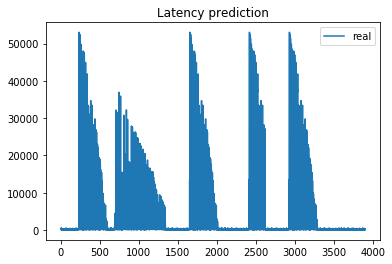

In [1550]:
plot(list(range(len(prediction_latency))), y_test, "real", "Latency prediction")

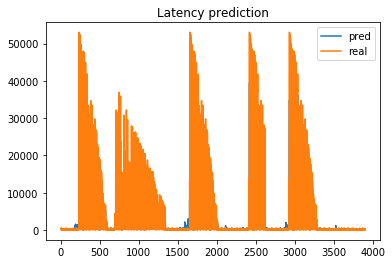

In [1543]:
plot2(list(range(len(prediction_latency))), prediction_latency, y_test, "pred", "real", "Latency prediction")

In [1544]:
def plot_dots(x, y, l, title):
    plt.clf()
    plt.scatter(x, y, s=0.5)
    plt.title(title)
    plt.show()

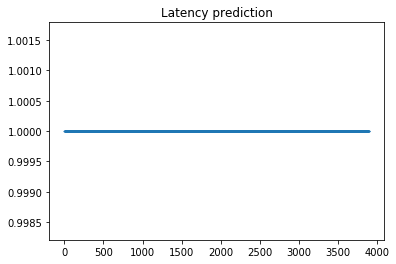

In [1545]:
plot_dots(list(range(len(prediction_latency))), prediction_latency > thresh, "pred", "Latency prediction")

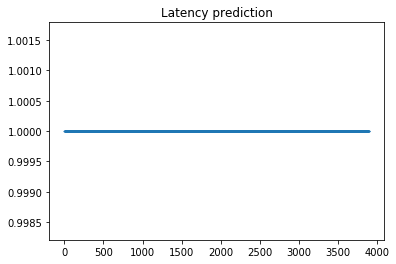

In [1546]:
plot_dots(list(range(len(prediction_latency))), y_test > thresh, "real", "Latency prediction")

In [1547]:
print(f'Total preficted fuckups: {(prediction_latency > thresh).sum()}')
print(f'Total real fuckups: {(y_test > thresh).sum()}')
print(f'Total diff: {np.logical_xor(y_test > thresh, prediction_latency > thresh).sum()}')
print(f'Total false positive: {(((prediction_latency > thresh).astype(int) - (y_test > thresh).astype(int)) == 1).sum()}')
print(f'Total predict zero but real true: {(((y_test > thresh).astype(int) - (prediction_latency > thresh).astype(int)) == 1).sum()}')

Total preficted fuckups: 3898
Total real fuckups: 3898
Total diff: 0
Total false positive: 0
Total predict zero but real true: 0


In [1548]:
X_test_hvm = hvm.get_test().to_numpy()
predictions = hvm.predict_batch(X_test_hvm)
predictions = predictions.swapaxes(0, 1)

NameError: name 'hvm' is not defined

In [ ]:
predictions.shape

In [606]:
a = np.random.rand(3)

In [607]:
a

array([0.09524538, 0.5252328 , 0.51086932])

In [702]:
b = np.random.rand(3)

In [609]:
b

array([0.08409607, 0.22102178, 0.93817246])

In [610]:
np.hstack([a, b])

array([0.09524538, 0.5252328 , 0.51086932, 0.08409607, 0.22102178,
       0.93817246])

In [611]:
np.vstack([a, b])

array([[0.09524538, 0.5252328 , 0.51086932],
       [0.08409607, 0.22102178, 0.93817246]])